In [1]:
from transformers import AutoProcessor, Wav2Vec2Model
import torch
from datasets import load_dataset
from collect_data import *
from collect_metrics import *
from sklearn.linear_model import Ridge


/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

inputs = processor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")



Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
inputs.input_values.shape

torch.Size([1, 93680])

In [7]:
with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

[1, 292, 768]

## Dati Nostri

In [2]:
stimuli_path = meg_path + '/stimuli/audio'
wav_files_duration = {}

for filename in os.listdir(stimuli_path):
    if filename.endswith('.wav'): 
        file_path = os.path.join(stimuli_path, filename)
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        wav_files_duration[filename.rstrip('.wav')] = duration
print('WAVE FILES DURATION: ',wav_files_duration)
print('WAVE FILES WITH\ NUMBERS: ',task)
wav_list_without_numb = list(task.keys())


WAVE FILES DURATION:  {'lw1': 318.1481632653061, 'lw1_3': 53.072426303854876, 'lw1_2': 93.7512925170068, 'lw1_1': 75.44276643990929, 'lw1_0': 95.88167800453515, 'easy_money_7': 129.30312925170068, 'easy_money_6': 123.42730158730159, 'easy_money_4': 163.68920634920636, 'easy_money_5': 142.36866213151927, 'easy_money_3': 141.97519274376418, 'easy_money_0': 143.12875283446712, 'easy_money_2': 180.43360544217688, 'easy_money_1': 104.10834467120182, 'cable_spool_fort_4': 123.26390022675737, 'cable_spool_fort_5': 54.69605442176871, 'cable_spool_fort_3': 105.82820861678005, 'cable_spool_fort_2': 137.65614512471655, 'cable_spool_fort_1': 134.8726984126984, 'cable_spool_fort_0': 100.59777777777778, 'the_black_willow_9': 188.23668934240362, 'the_black_willow_8': 142.4142403628118, 'the_black_willow_7': 172.399410430839, 'the_black_willow_6': 128.21628117913832, 'the_black_willow_5': 81.94331065759637, 'the_black_willow_4': 110.45659863945578, 'the_black_willow_2': 125.23859410430839, 'the_black_

In [13]:
audio_input = []

In [22]:
audio_name = wav_list_without_numb[3]
subject = patient[0]
print('PATIENT: ', subject)
print('AUDIO_NAME: ', audio_name)


PATIENT:  01
AUDIO_NAME:  the_black_willow


In [23]:
for i in range(len(session)):
    print("SESSION: ", session[i])
    story_uid = int(task[audio_name])
    print("STORY_UID_OR_TASK: ", story_uid)
    raw = get_bids_raw(meg_path, subject, session[i], str(story_uid))
    for z in range(len(the_black_willow)):
        print("SOUND_ID: ", float(the_black_willow[z]))
        epochs_data = get_epochs(raw, float(story_uid), float(the_black_willow[z]))
        if (i == 0 and subject == '01'):
            audio_path = stimuli_path + '/' + audio_name + '_' + str(z) + '.wav'
            data_audio_chunks = []
            epoch_spectr = get_meg_from_raw_epochs(epochs_data)
            for j in range(epoch_spectr.shape[0]):
                start = epochs_data[j]._metadata["start"].item()
                duration = 3
                y, sr = librosa.load(audio_path, sr=sampling_audio, offset=start, duration=duration)
                if (y.shape[0] < duration*sampling_audio):   
                    # make padding         
                    pad_width = duration*sampling_audio - y.shape[0]
                    y = np.pad(y, (0, pad_width), mode='constant', constant_values=0)
                data_audio_chunks.append(y)
            audio_tensor_chunk = torch.tensor(data_audio_chunks)
            audio_input.append(audio_tensor_chunk)
            print('AUDIO_SPECTR_SHAPE: ', audio_tensor_chunk.shape)

SESSION:  0
STORY_UID_OR_TASK:  3
Reading 0 ... 1868999  =      0.000 ...  1868.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:47: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
SOUND_ID:  0.0
Adding metadata with 18 columns
358 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 358 events and 3201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
AUDIO_SPECTR_SHAPE:  torch.Size([358, 48000])
SOUND_ID:  1.0
Adding metada

/home/matteoc/spect-to-meg/code/collect_data.py:47: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
SOUND_ID:  0.0
Adding metadata with 18 columns
358 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 358 events and 3201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
SOUND_ID:  1.0
Adding metadata with 18 columns
262 matching events found
A

In [24]:
print(len(audio_input))
# combined_tensor = torch.cat(audio_input, dim=0)

30


In [26]:
tensor_list_train = []
tensor_list_valid = []
tensor_list_test = []
for file_tensor in audio_input:
    train_tensor, val_tensor, test_tensor = split_tensor(file_tensor)
    tensor_list_train.append(train_tensor)
    tensor_list_valid.append(val_tensor)
    tensor_list_test.append(test_tensor)
audio_tensor_train = torch.cat(tensor_list_train, dim=0)
audio_tensor_valid = torch.cat(tensor_list_valid, dim=0)
audio_tensor_test = torch.cat(tensor_list_test, dim=0)

audio_tensor_train = torch.cat((audio_tensor_train, audio_tensor_train), 0)
audio_tensor_valid = torch.cat((audio_tensor_valid, audio_tensor_valid), 0)
audio_tensor_test = torch.cat((audio_tensor_test, audio_tensor_test), 0)
print('DIMENSION_AUDIO_TENSOR_TRAIN: ', audio_tensor_train.shape)
print('DIMENSION_AUDIO_TENSOR_VALID: ', audio_tensor_valid.shape)
print('DIMENSION_AUDIO_TENSOR_TEST: ', audio_tensor_test.shape)



DIMENSION_AUDIO_TENSOR_TRAIN:  torch.Size([11958, 48000])
DIMENSION_AUDIO_TENSOR_VALID:  torch.Size([1684, 48000])
DIMENSION_AUDIO_TENSOR_TEST:  torch.Size([3480, 48000])


In [31]:
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

inputs = processor(audio_tensor_test, sampling_rate=sampling_audio, return_tensors="pt")

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
w2v_input_values = inputs.input_values.squeeze(0)

In [33]:
with torch.no_grad():
    outputs = model(w2v_input_values)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

[3480, 149, 768]

In [34]:
# save_pred_target_test = os.path.join(meg_path, 'collect_data/wave2vec_input_test.pt')
# torch.save(last_hidden_states, save_pred_target_test)

In [3]:
megsp_path = os.path.join(meg_path, 'collect_data/megsp')
megsp_list = os.listdir(megsp_path)

megsp_list_session_0 = [f for f in megsp_list if f.split('_')[1] == '0']
megsp_list_session_1 = [f for f in megsp_list if f.split('_')[1] == '1']

meg_0_tensor_train, meg_0_tensor_valid, meg_0_tensor_test = get_splitted_tensor(megsp_list_session_0, megsp_path)
meg_1_tensor_train, meg_1_tensor_valid, meg_1_tensor_test = get_splitted_tensor(megsp_list_session_1, megsp_path)
meg_tensor_train = torch.cat((meg_0_tensor_train, meg_1_tensor_train), 0)
meg_tensor_valid = torch.cat((meg_0_tensor_valid, meg_1_tensor_valid), 0)
meg_tensor_test = torch.cat((meg_0_tensor_test, meg_1_tensor_test), 0)
print('DIMENSION_MEG_TENSOR_TRAIN: ', meg_tensor_train.shape)
print('DIMENSION_MEG_TENSOR_VALID: ', meg_tensor_valid.shape)
print('DIMENSION_MEG_TENSOR_TEST: ', meg_tensor_test.shape)

DIMENSION_MEG_TENSOR_TRAIN:  torch.Size([11958, 208, 16, 26])
DIMENSION_MEG_TENSOR_VALID:  torch.Size([1684, 208, 16, 26])
DIMENSION_MEG_TENSOR_TEST:  torch.Size([3480, 208, 16, 26])


In [5]:
# not to run
w2v_input_tensor = torch.load(os.path.join(meg_path, 'collect_data/wave2vec_input.pt'))
w2v_input_tensor_test = torch.load(os.path.join(meg_path, 'collect_data/wave2vec_input_test.pt'))
pred_target = []
mse_scores = []
real_target = []
audio_train = w2v_input_tensor.reshape(w2v_input_tensor.shape[0], -1)
audio_test = w2v_input_tensor_test.reshape(w2v_input_tensor_test.shape[0], -1)

for channel in tqdm(range(num_channel)):   
    y_train = meg_tensor_train[:, channel, :, :].reshape(meg_tensor_train.shape[0], -1)
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)

    model = Ridge(alpha=5000, max_iter=1000)
    model.fit(audio_train, y_train)

    y_pred = model.predict(audio_test)
    mse = mean_squared_error(y_test, y_pred)
    pred_target.append(y_pred)
    real_target.append(y_test)
    mse_scores.append(mse)

    
save_pred_target = os.path.join(meg_path, 'collect_data/meg_prediction_ridge_w2v.pt')
torch.save(torch.tensor(pred_target), save_pred_target)
save_mse = os.path.join(meg_path, 'collect_data/meg_mse_ridge_w2v.pt')
torch.save(torch.tensor(mse_scores), save_mse)

100%|██████████| 208/208 [4:27:51<00:00, 77.27s/it]  


In [4]:
real_target = []
for channel in range(num_channel):
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)
    real_target.append(y_test)

pred_mse_scores = torch.load(os.path.join(meg_path, 'collect_data/meg_mse_ridge_w2v.pt'))
pred_meg_y = torch.load(os.path.join(meg_path, 'collect_data/meg_prediction_ridge_w2v.pt'))
pred_meg_y = pred_meg_y.permute(1, 0, 2)
real_target = torch.tensor(np.array(real_target))
real_target = real_target.permute(1, 0, 2)
print("PREDICTION_SHAPE:", pred_meg_y.shape)

PREDICTION_SHAPE: torch.Size([3480, 208, 416])


In [17]:
pred_meg_y = pred_meg_y.reshape(-1, num_channel, 16, 26)
real_target = real_target.reshape(-1, num_channel, 16, 26)
print(pred_meg_y.shape)
print(real_target.shape)

torch.Size([3480, 208, 16, 26])
torch.Size([3480, 208, 16, 26])


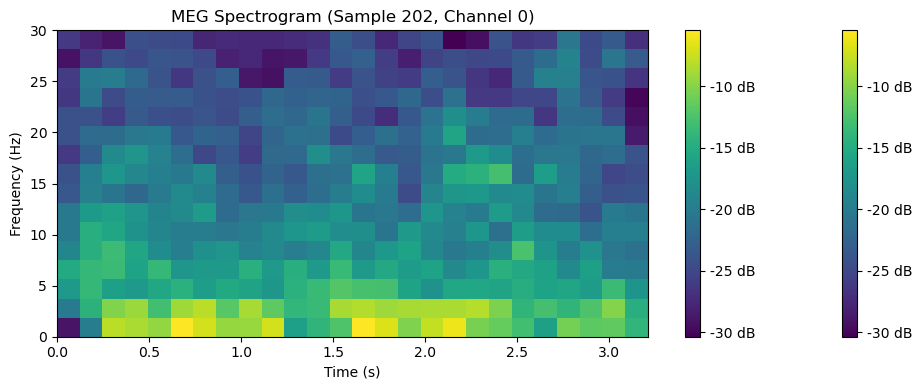

In [18]:
plot_spectrogram(pred_meg_y, sampling_meg, 202, 0)

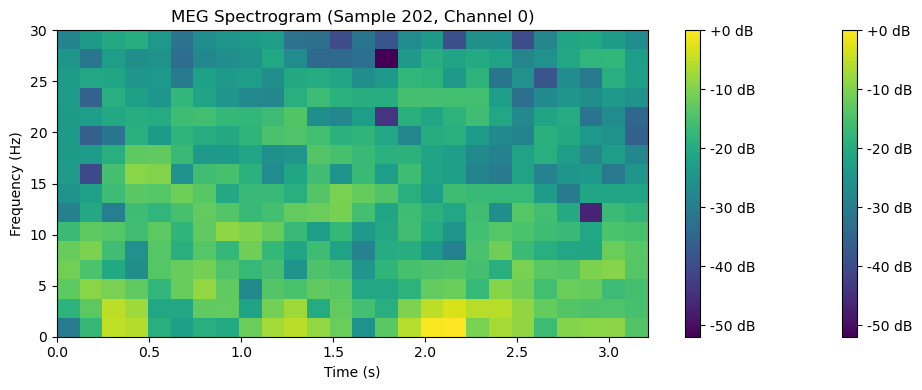

In [19]:
plot_spectrogram(real_target, sampling_meg, 202, 0)

In [10]:
# FREQUENCY BANDS METRICS

freq_bands = {
    'delta': [0, 2],
    'theta': [2, 4],
    'alpha': [4, 7],
    'beta': [7, 16],
}

metrics_by_band, corr_matrix_by_hand = bands_metrics(real_target, pred_meg_y, freq_bands)

for band_name, metrics_list in metrics_by_band.items():
    print(f'Metrics for {band_name} band:')
    for metrics in metrics_list:
        print(f"Channel {metrics['channel']}: Pearson Corr {metrics['pearson_corr']:.4f}, R^2 {metrics['r2']:.4f}, MSE {metrics['mse']:.4f}, MAE {metrics['mae']:.4f}")

delta_corr = corr_matrix_by_hand['delta'][0]['corr_matrix']


Metrics for delta band:
Channel 0: Pearson Corr 0.2575, R^2 -0.1006, MSE 63.6205, MAE 5.8934
Channel 1: Pearson Corr 0.1627, R^2 -0.1006, MSE 63.7647, MAE 5.9097
Channel 2: Pearson Corr -0.3599, R^2 -0.0998, MSE 64.5880, MAE 5.9237
Channel 3: Pearson Corr 0.2796, R^2 -0.1043, MSE 64.0798, MAE 5.9387
Channel 4: Pearson Corr 0.0006, R^2 -0.1012, MSE 64.9234, MAE 5.9418
Channel 5: Pearson Corr 0.0755, R^2 -0.0997, MSE 65.0813, MAE 5.9374
Channel 6: Pearson Corr 0.0787, R^2 -0.1016, MSE 66.4300, MAE 6.0644
Channel 7: Pearson Corr -0.0253, R^2 -0.0996, MSE 64.8421, MAE 5.9421
Channel 8: Pearson Corr 0.0270, R^2 -0.1036, MSE 66.4913, MAE 6.0801
Channel 9: Pearson Corr -0.2886, R^2 -0.1062, MSE 64.2530, MAE 5.9184
Channel 10: Pearson Corr 0.1471, R^2 -0.0958, MSE 64.3936, MAE 5.9173
Channel 11: Pearson Corr 0.6080, R^2 -0.1020, MSE 64.7079, MAE 5.9462
Channel 12: Pearson Corr 0.5824, R^2 -0.1030, MSE 64.4342, MAE 5.9251
Channel 13: Pearson Corr -0.0389, R^2 -0.1007, MSE 65.3058, MAE 5.9735
Ch

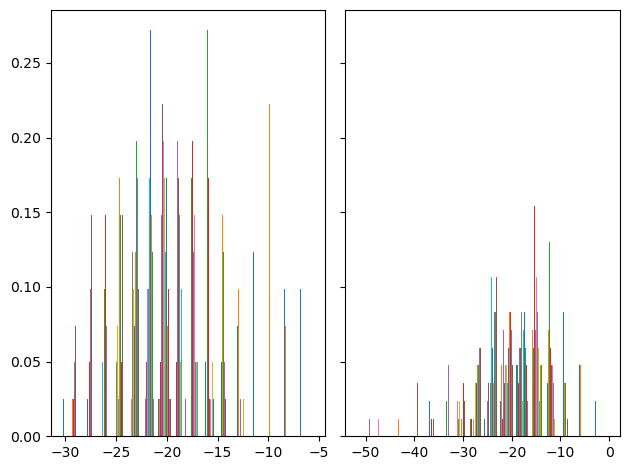

In [20]:
# KULLBACK DIVERGENCE

kl_lib, kl_mean, kl_div = get_kullback(pred_meg_y, real_target)


In [21]:
kl_div

tensor(119.3013, dtype=torch.float64)

## Pretrained Textual

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import mne_bids
from transformers import GPT2Tokenizer, GPT2LMHeadModel, CLIPTextModel, AutoTokenizer
from mne.datasets import sample
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)
import pickle
# from Contrastive import CLIPMEGConfig, CLIPMEGTransformer, CLIPTextMEGModel, CLIPMEGModel
import wandb


In [4]:
subject = patient[0]
epochs_list = []
for sess in session:
    print('---------', str(sess), '----------')
    for task in [0, 1, 2, 3]:
        print('---------', str(task), '----------')
        bids_path = mne_bids.BIDSPath(
            subject=subject,
            session=str(sess),
            task=str(task),
            datatype="meg",
            root=meg_path,
        )
        try:
            raw = mne_bids.read_raw_bids(bids_path)
        except FileNotFoundError:
            print("missing", subject, sess, task)
            pass
        raw = raw.pick_types(
            meg=True, misc=False, eeg=False, eog=False, ecg=False
        )
        raw.load_data().filter(0.5, 30.0, n_jobs=1)
        if task == 0:
            for sound_id in lw1:
                epochs = get_epochs(raw, float(task), float(sound_id))
                epochs_list.append(epochs)
        if task == 1:
            for sound_id in cable_spool_fort:
                epochs = get_epochs(raw, float(task), float(sound_id))
                epochs_list.append(epochs)
        if task == 2:
            for sound_id in easy_money:
                epochs = get_epochs(raw, float(task), float(sound_id))
                epochs_list.append(epochs)
        if task == 3:
            for sound_id in the_black_willow:
                epochs = get_epochs(raw, float(task), float(sound_id))
                epochs_list.append(epochs)

with open(meg_path+'/collect_data/text/epochs_list_subj01.pkl', 'wb') as f:
    pickle.dump(epochs_list, f)

       

--------- 0 ----------
--------- 0 ----------
Extracting SQD Parameters from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_events.tsv.
Reading channel info from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/tmp/ipykernel_1009150/3227635223.py:15: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6601 samples (6.601 s)

Adding metadata with 18 columns
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 3201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
139 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw f

/tmp/ipykernel_1009150/3227635223.py:15: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6601 samples (6.601 s)

Adding metadata with 18 columns
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 3201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
325 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw f

/tmp/ipykernel_1009150/3227635223.py:15: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6601 samples (6.601 s)

Adding metadata with 18 columns
257 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 257 events and 3201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
190 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw f

/tmp/ipykernel_1009150/3227635223.py:15: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6601 samples (6.601 s)

Adding metadata with 18 columns
358 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 358 events and 3201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
262 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw f

/tmp/ipykernel_1009150/3227635223.py:15: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6601 samples (6.601 s)

Adding metadata with 18 columns
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 3201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
139 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw f

/tmp/ipykernel_1009150/3227635223.py:15: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6601 samples (6.601 s)

Adding metadata with 18 columns
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 3201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
325 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw f

/tmp/ipykernel_1009150/3227635223.py:15: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6601 samples (6.601 s)

Adding metadata with 18 columns
257 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 257 events and 3201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
190 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw f

/tmp/ipykernel_1009150/3227635223.py:15: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6601 samples (6.601 s)

Adding metadata with 18 columns
358 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 358 events and 3201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
262 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw f

In [4]:
with open(meg_path+'/collect_data/text/epochs_list_subj01.pkl', 'rb') as f:
    loaded_epochs_list = pickle.load(f)

In [5]:
print(loaded_epochs_list[0])


<Epochs |  180 events (all good), -0.2 – 3 s, baseline -0.2 – 0 s, ~914.6 MB, data loaded, with metadata,
 '1': 180>


In [7]:
train_ratio = 0.7
val_ratio = 0.1

tensor_list_train = []
tensor_list_valid = []
tensor_list_test = []

for epoch in loaded_epochs_list:
    total_samples = len(epoch)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)
    train_tensor = epoch[:train_size]
    val_tensor = epoch[train_size:train_size + val_size]
    test_tensor = epoch[train_size + val_size:]
    tensor_list_train.append(train_tensor)
    tensor_list_valid.append(val_tensor)
    tensor_list_test.append(test_tensor)

concat_epochs_train = mne.concatenate_epochs(tensor_list_train)
concat_epochs_valid = mne.concatenate_epochs(tensor_list_valid)
concat_epochs_test = mne.concatenate_epochs(tensor_list_test)

concatenated_epochs = mne.concatenate_epochs(loaded_epochs_list)



/tmp/ipykernel_1009837/2023461499.py:19: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concat_epochs_train = mne.concatenate_epochs(tensor_list_train)


Adding metadata with 18 columns
11958 matching events found
Applying baseline correction (mode: mean)


/tmp/ipykernel_1009837/2023461499.py:20: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concat_epochs_valid = mne.concatenate_epochs(tensor_list_valid)


Adding metadata with 18 columns
1684 matching events found
Applying baseline correction (mode: mean)


/tmp/ipykernel_1009837/2023461499.py:21: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concat_epochs_test = mne.concatenate_epochs(tensor_list_test)


Adding metadata with 18 columns
3480 matching events found
Applying baseline correction (mode: mean)


/tmp/ipykernel_1009837/2023461499.py:23: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(loaded_epochs_list)


Adding metadata with 18 columns
17122 matching events found
Applying baseline correction (mode: mean)


In [8]:
concatenated_epochs

Number of events,17122
Events,1: 17122
Time range,-0.200 – 3.000 s
Baseline,-0.200 – 0.000 s


In [9]:
X = concatenated_epochs.get_data()
y = concatenated_epochs.metadata.word.to_numpy()
X_sent, y_sent = build_phrase_dataset(X, y)

In [ ]:
print(X.shape)
print(y.shape)